# Imports e carregamentos

In [42]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [43]:
df = pd.read_csv('data_live_engineer.csv', encoding='utf-8')

In [44]:
df['result'].value_counts()

result
0    483769
1    158536
Name: count, dtype: int64

# Analisando a importancia das ligas depois da engenharia de características

## Preprocessamento

In [45]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)

# Verificar a presença de valores infinitos (as vezes existem divisões por zero)
print(df.replace([np.inf, -np.inf], np.nan).isnull().sum())

# Substituir infinitos por NaN e então por um valor numérico ou excluir essas linhas
# df.replace([np.inf, -np.inf], np.nan, inplace=True)

# # substituído pelo último valor não-NaN anterior na coluna.
# df.fillna(method='ffill', inplace=True)

minute                               0
homeTeam                             0
awayTeam                             0
goalHome                             0
goalAway                             0
                                    ..
timeSinceLastEventPasses_Away        0
timeSinceLastEventFouls_Home         0
timeSinceLastEventFouls_Away         0
timeSinceLastEventTotalCards_Home    0
timeSinceLastEventTotalCards_Away    0
Length: 62, dtype: int64


## Treinando modelo de cada liga

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline

# Lista das ligas únicas no conjunto de dados
leagues = df['league'].unique()

# Dicionário para armazenar histórico de treinamento e avaliação para cada liga
league_histories = {}

# Loop por cada liga para criar, treinar e avaliar um modelo separado
for league in leagues:
    print(f"Treinando modelo para a liga: {league}")
    
    # Filtrando o conjunto de dados para apenas a liga atual
    league_data = df[df['league'] == league]
    
    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    y = league_data['result']

    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)

    
    model_randomf = RandomForestClassifier(n_estimators=100, random_state=42, 
                                           max_depth=10, min_samples_split=5, 
                                            min_samples_leaf=2)
    # Validação cruzada
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='roc_auc')
    print(f"Média AUC para {league}: {cv_scores.mean()}")

    # Treinando e avaliando o modelo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_randomf.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, model_randomf.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model_randomf.predict_proba(X_test)[:, 1])

    feature_importance = model_randomf.feature_importances_

    # Armazenando a avaliação em um dicionário
    league_histories[league] = {
        'cv_auc_mean': cv_scores.mean(),
        'train_auc': train_auc,
        'test_auc': test_auc,
        'feature_importance': feature_importance
    }

    # Predicting the values
    y_pred = model_randomf.predict(X_test)
    
    # classification report
    print(classification_report(y_test, y_pred))
    print()

Treinando modelo para a liga: South America - Copa Libertadores
Média AUC para South America - Copa Libertadores: 0.5300631800025315
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3121
           1       0.92      0.16      0.28      1091

    accuracy                           0.78      4212
   macro avg       0.85      0.58      0.58      4212
weighted avg       0.81      0.78      0.72      4212


Treinando modelo para a liga: Asia - AFC Champions League
Média AUC para Asia - AFC Champions League: 0.4398416577208325
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2534
           1       0.98      0.20      0.33       886

    accuracy                           0.79      3420
   macro avg       0.88      0.60      0.60      3420
weighted avg       0.83      0.79      0.73      3420


Treinando modelo para a liga: Brazil - Paulista A1
Média AUC para Brazil - Paulista A1: 0.

## Avaliando importancia das features de cada liga

In [47]:
# # Suponha que X_train tenha os nomes das features e league_histories contenha as importâncias
# feature_names = X.columns

# # Loop para criar um gráfico para cada liga
# for league, data in league_histories.items():
#     # Ordenar as características e suas importâncias
#     sorted_idx = np.argsort(data['feature_importance'])
#     sorted_feature_names = feature_names[sorted_idx]
#     sorted_importances = data['feature_importance'][sorted_idx]

#     # Criando o gráfico
#     plt.figure(figsize=(10, 8))
#     plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
#     plt.title(f'Feature Importance for {league}')
#     plt.xlabel('Importance')
#     plt.ylabel('Features')
#     plt.show()


## Visualizando média e variância da importância das ligas

In [48]:
dataframe_league = pd.DataFrame.from_dict(league_histories, orient='index')
# dataframe_league.to_csv('dataframe_leagues_avaliation_before_f_engineering.csv', index=False, encoding='utf-8')
dataframe_league

,cv_auc_mean,train_auc,test_auc,feature_importance
South America - Copa Libertadores,0.530063,0.965528,0.919206,"[0.03307918140976862, 0.011574493454515293, 0...."
Asia - AFC Champions League,0.439842,0.983280,0.950340,"[0.028640484319078327, 0.013062307701669822, 0..."
Brazil - Paulista A1,0.487860,0.989293,0.964225,"[0.024760473189351723, 0.009701708954692127, 0..."
South America - Copa Sudamericana,0.483241,0.989849,0.959479,"[0.023351323510572182, 0.008887167788666508, 0..."
Japan - J-League,0.492868,0.965579,0.924226,"[0.03245939246202793, 0.012974550277956621, 0...."
USA - Major League Soccer,0.534961,0.916403,0.855386,"[0.04245843687956908, 0.01774182949772992, 0.0..."
Mexico - Liga MX,0.484657,0.972519,0.924713,"[0.03450946878495869, 0.011033912995533014, 0...."
Scotland - Premiership,0.449960,0.982832,0.938271,"[0.027236631793548592, 0.011668418611549434, 0..."
Brazil - Serie A,0.547653,0.930561,0.883005,"[0.03662048597828373, 0.008170853709097373, 0...."
France - Ligue 1,0.505105,0.981085,0.943546,"[0.03127251687528093, 0.013693372184221455, 0...."


In [49]:
# We calculate the mean importance for each feature across all leagues
mean_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist()).mean().tolist()

# First, let's convert the list of feature importances into a DataFrame for easier analysis
df_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist())

# Calculating the variance of each feature's importance across all leagues
feature_variances = df_feature_importances.var()

# Creating a summary DataFrame to hold the variance and correlation data
summary_df = pd.DataFrame({
    'Mean Importance': mean_feature_importances,
    'Variance': feature_variances,
})

# Display the summary dataframe sorted by variance to see which features have the most variability across leagues
summary_df.sort_values('Variance', ascending=False, inplace=True)
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Feature'}, inplace=True)

feature_names = df.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1).columns

# Mapeando os números para os nomes das características
summary_df['Feature Name'] = summary_df['Feature'].apply(lambda x: feature_names[x])
summary_df.sort_values('Mean Importance', ascending=False)

,Feature,Mean Importance,Variance,Feature Name
1,47,0.042295,2.737358e-05,timeSinceLastEvent_Home
4,48,0.041598,2.393828e-05,timeSinceLastEvent_Away
3,55,0.035820,2.425946e-05,timeSinceLastEventTotalCards_Home
9,56,0.035162,1.387866e-05,timeSinceLastEventTotalCards_Away
10,39,0.033142,1.279676e-05,defensiveEfficacy
5,0,0.030465,2.343716e-05,minute
19,23,0.028786,9.837376e-06,possessiontime_away
12,24,0.028295,1.182479e-05,possessiontime_home
28,25,0.027831,7.112687e-06,shotsOnGoalEfficiency
13,40,0.027262,1.181067e-05,defensiveAggression


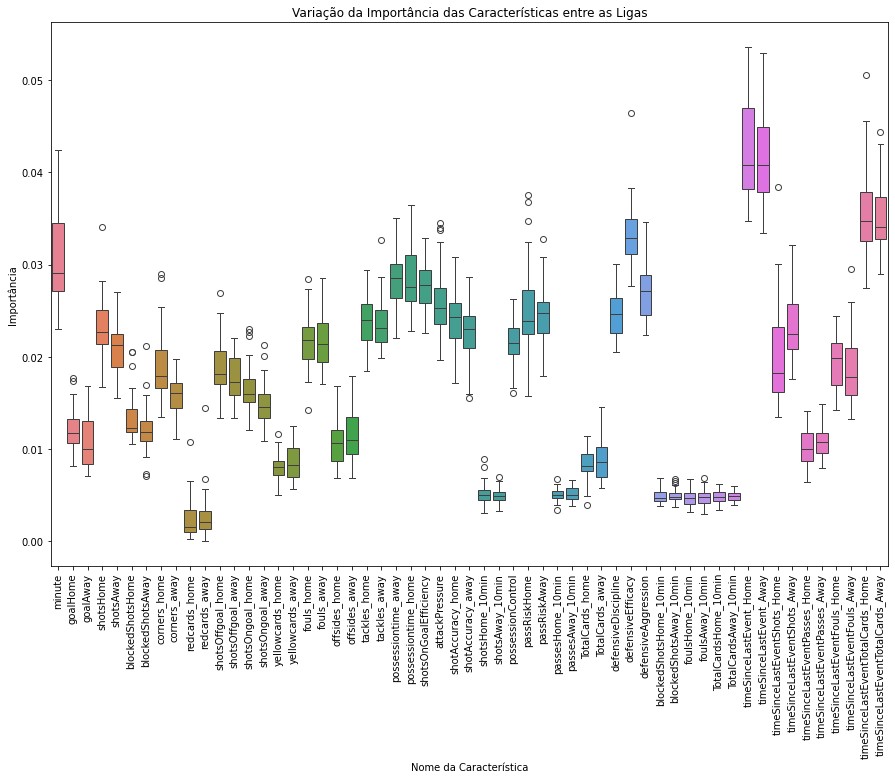

In [50]:
def convert_to_list(ndarray):
    # Verifica se o ndarray não é vazio e converte para lista
    return ndarray.tolist() if ndarray.size else []

importance_lists = dataframe_league['feature_importance'].apply(convert_to_list)

# Criando um DataFrame para armazenar os valores de importância para todas as ligas
feature_importance_df = pd.DataFrame(importance_lists.tolist())

# Calculando estatísticas descritivas para cada característica em todas as ligas
feature_importance_stats = feature_importance_df.describe()

# feature_names = summary_df['Feature Name'].tolist()

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.show()


- Variação na Importância: Características com boxplots mais largos indicam uma maior variação na sua importância entre as ligas. Isso sugere que o impacto dessas características é mais específico para cada liga. Por outro lado, características com boxplots mais estreitos mostram uma consistência maior, indicando que a importância dessas características é mais uniforme entre as ligas.
Outliers:

- Alguns boxplots têm pontos outliers, que representam ligas onde a importância da característica é notavelmente diferente do padrão observado na maioria das outras ligas. Esses outliers podem indicar casos específicos onde uma característica é particularmente mais ou menos relevante.

- Modelos Personalizados para Ligas: As características com maior variação (boxplots mais largos e/ou com outliers) são fortes candidatas a justificar a criação de modelos separados para cada liga. Isso permitiria que os modelos levassem em conta as peculiaridades de cada liga, resultando em previsões mais precisas.

- Características com menor variação podem ser tratadas de forma mais consistente entre os modelos para diferentes ligas.

## Analisando características com baixa importancia

In [51]:
summary_df.sort_values('Mean Importance', ascending=False)

,Feature,Mean Importance,Variance,Feature Name
1,47,0.042295,2.737358e-05,timeSinceLastEvent_Home
4,48,0.041598,2.393828e-05,timeSinceLastEvent_Away
3,55,0.035820,2.425946e-05,timeSinceLastEventTotalCards_Home
9,56,0.035162,1.387866e-05,timeSinceLastEventTotalCards_Away
10,39,0.033142,1.279676e-05,defensiveEfficacy
5,0,0.030465,2.343716e-05,minute
19,23,0.028786,9.837376e-06,possessiontime_away
12,24,0.028295,1.182479e-05,possessiontime_home
28,25,0.027831,7.112687e-06,shotsOnGoalEfficiency
13,40,0.027262,1.181067e-05,defensiveAggression


In [52]:
summary_df.sort_values('Variance', ascending=False)

,Feature,Mean Importance,Variance,Feature Name
0,49,0.020228,3.007758e-05,timeSinceLastEventShots_Home
1,47,0.042295,2.737358e-05,timeSinceLastEvent_Home
2,32,0.024995,2.569324e-05,passRiskHome
3,55,0.035820,2.425946e-05,timeSinceLastEventTotalCards_Home
4,48,0.041598,2.393828e-05,timeSinceLastEvent_Away
5,0,0.030465,2.343716e-05,minute
6,7,0.019060,1.538787e-05,corners_home
7,54,0.018654,1.519408e-05,timeSinceLastEventFouls_Away
8,26,0.026132,1.412045e-05,attackPressure
9,56,0.035162,1.387866e-05,timeSinceLastEventTotalCards_Away


In [53]:
summary_df.to_csv('summary_df.csv', index=False, encoding='utf-8')

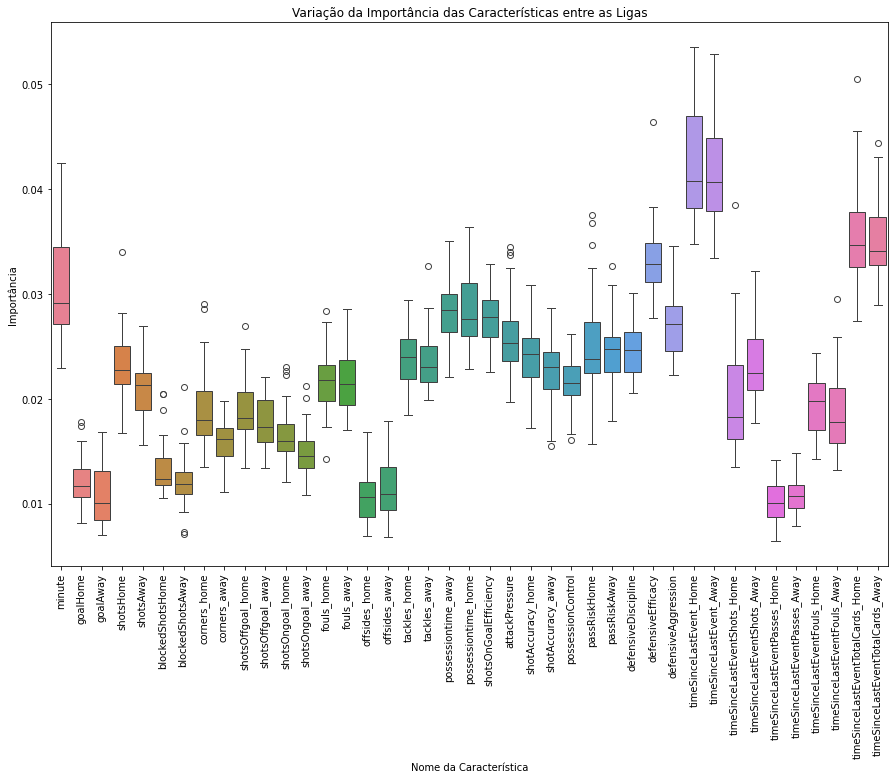

In [61]:
low_importance_features_indices1 = summary_df[summary_df['Mean Importance'] < 0.01 ]['Feature'].tolist()
# low_importance_features_indices2 = summary_df[summary_df['Variance'] > 0.000043]['Feature'].tolist()
# low_importance_features_indices = low_importance_features_indices1 + low_importance_features_indices2
low_importance_features_indices = low_importance_features_indices1 

feature_importance_df_filtered = feature_importance_df.drop(columns=low_importance_features_indices, axis=1)

feature_names_filtered = [feature_names[i] for i in range(len(feature_names)) if i not in low_importance_features_indices]

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df_filtered)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names_filtered)), labels=feature_names_filtered, rotation=90)
plt.show()


In [65]:
features_to_drop = [feature_names[i] for i in low_importance_features_indices]
features_to_drop

['redcards_away',
 'redcards_home',
 'TotalCards_away',
 'yellowcards_away',
 'TotalCards_home',
 'yellowcards_home',
 'shotsHome_10min',
 'foulsHome_10min',
 'foulsAway_10min',
 'shotsAway_10min',
 'blockedShotsAway_10min',
 'TotalCardsHome_10min',
 'passesHome_10min',
 'passesAway_10min',
 'blockedShotsHome_10min',
 'TotalCardsAway_10min']

- Características com Baixa Importância: As características que têm importância média muito baixa e variância alta podem ser excluídas, pois provavelmente não contribuirão significativamente para o modelo ou podem introduzir ruído. 

In [66]:
df = pd.read_csv('data_live_engineer.csv', encoding='utf-8')
df.drop(features_to_drop, axis=1, inplace=True)
df.to_csv("data_live_engineer_filtered.csv", index=False, encoding="utf-8")

In [67]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway', 'shotsHome',
       'shotsAway', 'blockedShotsHome', 'blockedShotsAway', 'league',
       'corners_home', 'corners_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'fouls_home', 'fouls_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home', 'shotsOnGoalEfficiency',
       'attackPressure', 'shotAccuracy_home', 'shotAccuracy_away',
       'possessionControl', 'passRiskHome', 'passRiskAway',
       'defensiveDiscipline', 'defensiveEfficacy', 'defensiveAggression',
       'timeSinceLastEvent_Home', 'timeSinceLastEvent_Away',
       'timeSinceLastEventShots_Home', 'timeSinceLastEventShots_Away',
       'timeSinceLastEventPasses_Home', 'timeSinceLastEventPasses_Away',
       'timeSinceLastEventFouls_Home', 'timeSinceLastEventFouls_Away',
       'timeSinceLastEventTotalCards_Ho

In [68]:
# # Função para criar e aplicar o transformador de colunas
# def create_preprocessor(X):
#     numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', StandardScaler(), numeric_features),
#         ],
#         remainder='passthrough'  # Mantém as características categóricas sem transformação
#     )
#     return preprocessor.fit(X)

# # Preparando os dados de entrada e saída
# X = df.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
# y = df['result']

# preprocessor = create_preprocessor(X)
# X_transformed = preprocessor.transform(X)

# # Salvando o preprocessador para uso futuro
# with open('../models/preprocessor_league.pickle', 'wb') as f:
#     pickle.dump(preprocessor, f)
#     print("Preprocessador salvo em '../models/preprocessor_league.pickle'.")

# # Verificar a presença de valores infinitos (as vezes existem divisões por zero)
# # print(df.replace([np.inf, -np.inf], np.nan).isnull().sum())

# # # Substituir infinitos por NaN e então por um valor numérico ou excluir essas linhas
# # df.replace([np.inf, -np.inf], np.nan, inplace=True)

# # # substituído pelo último valor não-NaN anterior na coluna.
# # df.fillna(method='ffill', inplace=True)

## Treinando modelo de cada liga

In [69]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, roc_auc_score
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.pipeline import make_pipeline

# # Lista das ligas únicas no conjunto de dados
# leagues = df['league'].unique()

# # Dicionário para armazenar histórico de treinamento e avaliação para cada liga
# league_histories = {}

# # Loop por cada liga para criar, treinar e avaliar um modelo separado
# for league in leagues:
#     print(f"Treinando modelo para a liga: {league}")
    
#     # Filtrando o conjunto de dados para apenas a liga atual
#     league_data = df[df['league'] == league]
    
#     # Preparando os dados de entrada e saída
#     X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
#     y = league_data['result']

#     preprocessor = create_preprocessor(X)
#     X_transformed = preprocessor.transform(X)

    
#     model_randomf = RandomForestClassifier(n_estimators=100, random_state=42, 
#                                            max_depth=10, min_samples_split=5, 
#                                             min_samples_leaf=2)
#     # Validação cruzada
#     cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='roc_auc')
#     print(f"Média AUC para {league}: {cv_scores.mean()}")

#     # Treinando e avaliando o modelo
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     model_randomf.fit(X_train, y_train)
#     train_auc = roc_auc_score(y_train, model_randomf.predict_proba(X_train)[:, 1])
#     test_auc = roc_auc_score(y_test, model_randomf.predict_proba(X_test)[:, 1])

#     feature_importance = model_randomf.feature_importances_

#     # Armazenando a avaliação em um dicionário
#     league_histories[league] = {
#         'cv_auc_mean': cv_scores.mean(),
#         'train_auc': train_auc,
#         'test_auc': test_auc,
#         'feature_importance': feature_importance
#     }

#     # Predicting the values
#     y_pred = model_randomf.predict(X_test)
    
#     # classification report
#     print(classification_report(y_test, y_pred))
#     print()

#     # salvando o modelo
#     filename = f'../models/model_randomf_{league}.sav'
#     pickle.dump(model_randomf, open(filename, 'wb'))
